## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-06 15:58:42.140 | INFO     |  Running on cpu


In [3]:
task = 'BlockTableRed'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-08-06 15:58:47.467 | INFO     |  Loading dataset(s): 
2025-08-06 15:58:47.468 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockTableRed/demos/metadata.json
2025-08-06 15:58:47.472 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-06 15:58:47.472 | INFO     |    Extracted tsdf object labels []
2025-08-06 15:58:47.472 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=t

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([163, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([163]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([163, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([163, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([163, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([163, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    min_end_distance=20
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-06 15:58:58.861 | INFO     |  Fitting AutoTPGMM
2025-08-06 15:58:58.861 | INFO     |  Performing fitting actions: [INIT]
2025-08-06 15:58:58.861 | INFO     |  Segmenting trajectories


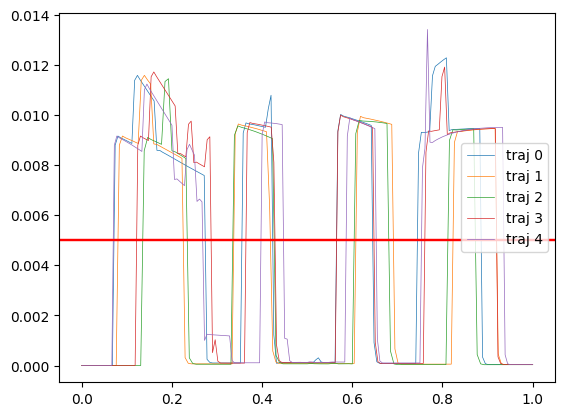

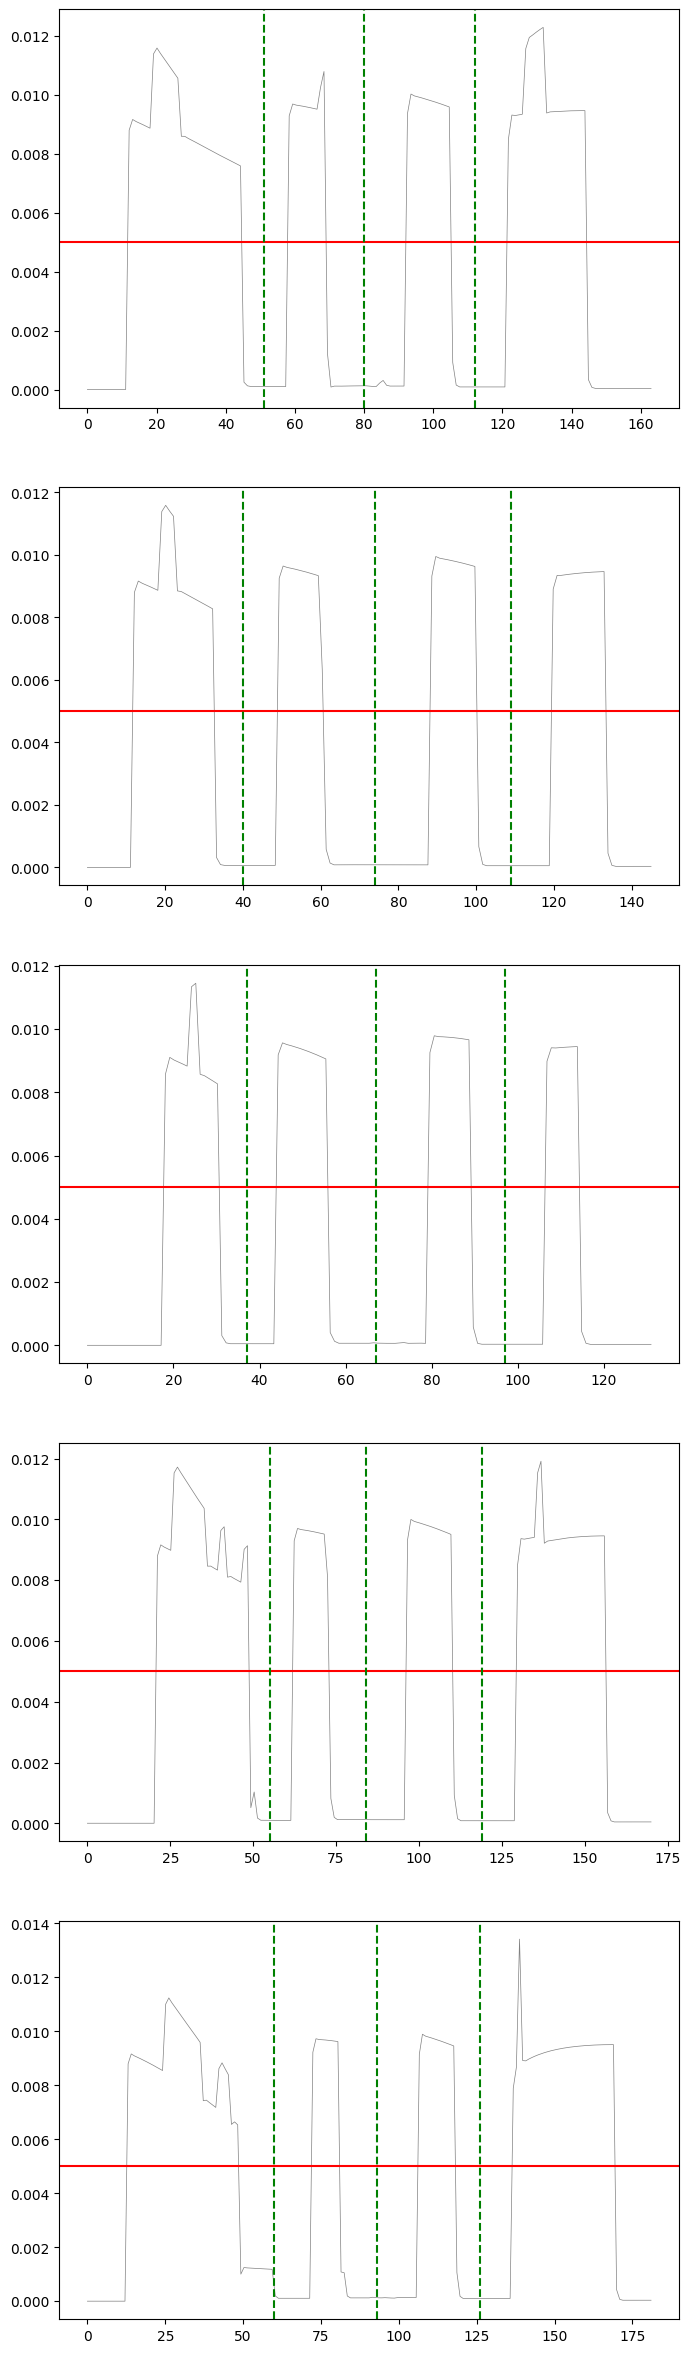

2025-08-06 15:59:00.830 | INFO     |  Creating segement of demos.
2025-08-06 15:59:00.945 | INFO     |  Subsampling to length 57 using strategy mean-length.
2025-08-06 15:59:00.958 | INFO     |  Creating segement of demos.
2025-08-06 15:59:00.973 | INFO     |  Subsampling to length 40 using strategy mean-length.
2025-08-06 15:59:00.974 | INFO     |  Creating segement of demos.
2025-08-06 15:59:00.983 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-06 15:59:00.984 | INFO     |  Creating segement of demos.
2025-08-06 15:59:00.993 | INFO     |  Subsampling to length 54 using strategy mean-length.
2025-08-06 15:59:00.994 | INFO     |  ... created 4 segments
2025-08-06 15:59:00.994 | INFO     |    Fitting candidate frame 1/10
2025-08-06 15:59:00.994 | INFO     |    Creating partial frame view of demos.
2025-08-06 15:59:01.023 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-06 15:59:01.023 | INFO     |    Changing number of components to 4
2025-08-06 15:59:

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:01.358 | INFO     |    Fitting candidate frame 2/10
2025-08-06 15:59:01.359 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:01.910 | INFO     |    Fitting candidate frame 3/10
2025-08-06 15:59:01.911 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:02.858 | INFO     |    Fitting candidate frame 4/10
2025-08-06 15:59:02.885 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:04.002 | INFO     |    Fitting candidate frame 5/10
2025-08-06 15:59:04.004 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:04.909 | INFO     |    Fitting candidate frame 6/10
2025-08-06 15:59:04.910 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:05.340 | INFO     |    Fitting candidate frame 7/10
2025-08-06 15:59:05.341 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:05.771 | INFO     |    Fitting candidate frame 8/10
2025-08-06 15:59:05.771 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:06.186 | INFO     |    Fitting candidate frame 9/10
2025-08-06 15:59:06.186 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:06.516 | INFO     |    Fitting candidate frame 10/10
2025-08-06 15:59:06.517 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:06.978 | INFO     |  ee_init    score (rel):     -0 (0.165)
2025-08-06 15:59:06.987 | INFO     |  obj000     score (rel):     -0 (0.165)
2025-08-06 15:59:06.987 | INFO     |  obj001     score (rel):     -0 (0.165)
2025-08-06 15:59:06.988 | INFO     |  obj002     score (rel):     -0 (0.165)
2025-08-06 15:59:06.988 | INFO     |  obj003     score (rel):     -0 (0.165)
2025-08-06 15:59:06.989 | INFO     |  obj004     score (rel):     -0 (0.165)
2025-08-06 15:59:06.990 | INFO     |  obj005     score (rel):     -0 (0.165)
2025-08-06 15:59:06.991 | INFO     |  obj006     score (rel):     -1 (1.000)
2025-08-06 15:59:06.991 | INFO     |  obj007     score (rel):     -0 (0.004)
2025-08-06 15:59:06.991 | INFO     |  obj008     score (rel):     -0 (0.002)
2025-08-06 15:59:07.170 | INFO     |  Creating partial frame view of demos.
2025-08-06 15:59:07.213 | INFO     |    Fitting candidate frame 1/10
2025-08-06 15:59:07.214 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:07.704 | INFO     |    Fitting candidate frame 2/10
2025-08-06 15:59:07.722 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:08.202 | INFO     |    Fitting candidate frame 3/10
2025-08-06 15:59:08.204 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:08.534 | INFO     |    Fitting candidate frame 4/10
2025-08-06 15:59:08.535 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:08.903 | INFO     |    Fitting candidate frame 5/10
2025-08-06 15:59:08.903 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:09.207 | INFO     |    Fitting candidate frame 6/10
2025-08-06 15:59:09.207 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:09.446 | INFO     |    Fitting candidate frame 7/10
2025-08-06 15:59:09.447 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:09.681 | INFO     |    Fitting candidate frame 8/10
2025-08-06 15:59:09.682 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:09.976 | INFO     |    Fitting candidate frame 9/10
2025-08-06 15:59:09.978 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:10.271 | INFO     |    Fitting candidate frame 10/10
2025-08-06 15:59:10.272 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:10.613 | INFO     |  ee_init    score (rel):     -0 (0.025)
2025-08-06 15:59:10.613 | INFO     |  obj000     score (rel):     -0 (0.025)
2025-08-06 15:59:10.613 | INFO     |  obj001     score (rel):     -0 (0.025)
2025-08-06 15:59:10.613 | INFO     |  obj002     score (rel):     -0 (0.025)
2025-08-06 15:59:10.613 | INFO     |  obj003     score (rel):     -0 (0.025)
2025-08-06 15:59:10.614 | INFO     |  obj004     score (rel):     -0 (0.025)
2025-08-06 15:59:10.614 | INFO     |  obj005     score (rel):     -0 (0.025)
2025-08-06 15:59:10.614 | INFO     |  obj007     score (rel):     -0 (0.003)
2025-08-06 15:59:10.660 | INFO     |  Creating partial frame view of demos.
2025-08-06 15:59:10.663 | INFO     |    Fitting candidate frame 1/10
2025-08-06 15:59:10.663 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:10.976 | INFO     |    Fitting candidate frame 2/10
2025-08-06 15:59:10.978 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:11.326 | INFO     |    Fitting candidate frame 3/10
2025-08-06 15:59:11.326 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:11.731 | INFO     |    Fitting candidate frame 4/10
2025-08-06 15:59:11.732 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:12.021 | INFO     |    Fitting candidate frame 5/10
2025-08-06 15:59:12.022 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:12.253 | INFO     |    Fitting candidate frame 6/10
2025-08-06 15:59:12.253 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:12.535 | INFO     |    Fitting candidate frame 7/10
2025-08-06 15:59:12.536 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:12.834 | INFO     |    Fitting candidate frame 8/10
2025-08-06 15:59:12.835 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:13.160 | INFO     |    Fitting candidate frame 9/10
2025-08-06 15:59:13.161 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:13.470 | INFO     |    Fitting candidate frame 10/10
2025-08-06 15:59:13.471 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-06 15:59:13.941 | INFO     |  ee_init    score (rel):     -0 (0.040)
2025-08-06 15:59:13.950 | INFO     |  obj000     score (rel):     -0 (0.040)
2025-08-06 15:59:13.950 | INFO     |  obj001     score (rel):     -0 (0.040)
2025-08-06 15:59:13.950 | INFO     |  obj002     score (rel):     -0 (0.040)
2025-08-06 15:59:13.950 | INFO     |  obj003     score (rel):     -0 (0.040)
2025-08-06 15:59:13.953 | INFO     |  obj004     score (rel):     -0 (0.040)
2025-08-06 15:59:13.954 | INFO     |  obj005     score (rel):     -0 (0.040)
2025-08-06 15:59:13.954 | INFO     |  obj007     score (rel):     -0 (0.002)
2025-08-06 15:59:14.055 | INFO     |  Creating partial frame view of demos.
2025-08-06 15:59:14.098 | INFO     |    Fitting candidate frame 1/10
2025-08-06 15:59:14.102 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 15:59:16.909 | INFO     |    Fitting candidate frame 2/10
2025-08-06 15:59:17.028 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:21.715 | INFO     |    Fitting candidate frame 3/10
2025-08-06 16:00:21.716 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:22.041 | INFO     |    Fitting candidate frame 4/10
2025-08-06 16:00:22.042 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:22.431 | INFO     |    Fitting candidate frame 5/10
2025-08-06 16:00:22.432 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:22.874 | INFO     |    Fitting candidate frame 6/10
2025-08-06 16:00:22.875 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:23.376 | INFO     |    Fitting candidate frame 7/10
2025-08-06 16:00:23.377 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:23.876 | INFO     |    Fitting candidate frame 8/10
2025-08-06 16:00:23.877 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:24.255 | INFO     |    Fitting candidate frame 9/10
2025-08-06 16:00:24.256 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:24.796 | INFO     |    Fitting candidate frame 10/10
2025-08-06 16:00:24.797 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:25.266 | INFO     |  ee_init    score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj000     score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj001     score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj002     score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj003     score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj004     score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj005     score (rel):     -0 (0.187)
2025-08-06 16:00:25.267 | INFO     |  obj008     score (rel):     -0 (0.003)
2025-08-06 16:00:25.269 | INFO     |  Creating partial frame view of demos.
2025-08-06 16:00:25.272 | INFO     |  Segmented trajs into 4 segments
2025-08-06 16:00:25.327 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142485 -0.142485 -0.142485 -0.142485 -0.142485 -0.142485   
Segment 1 -0.021432 -0.021433 -0.02

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[1.37e+08, 1.37e+08, 1.32e+08, ..., 2.80e-18, 3.58e-19, 4.42e-20],
         [2.93e+07, 3.51e+07, 4.14e+07, ..., 8.06e+00, 4.34e+00, 2.30e+00],
         [1.04e+04, 1.55e+04, 2.26e+04, ..., 1.72e+07, 1.20e+07, 8.15e+06],
         [7.37e-29, 3.01e-28, 1.20e-27, ..., 1.30e+09, 1.18e+09, 1.04e+09]]),
  array([[2.47e+09, 2.47e+09, 2.39e+09, 2.24e+09, 2.04e+09, 1.79e+09,
          1.53e+09, 1.26e+09, 9.29e+08, 5.61e+08, 4.20e+08, 2.01e+08,
          7.89e+07, 2.54e+07, 6.73e+06, 1.47e+06, 2.64e+05, 3.91e+04,
          5.15e+03, 5.91e+02, 3.42e+02, 1.79e+02, 9.23e+01, 4.63e+01,
          2.24e+01, 1.05e+01, 4.78e+00, 2.10e+00, 8.96e-01, 3.70e-01,
          1.46e-01, 5.60e-02, 2.08e-02, 7.47e-03, 2.60e-03, 8.77e-04,
          2.87e-04, 9.06e-05, 2.78e-05, 8.24e-06, 2.39e+09, 2.40e+09,
          2.32e+09, 2.18e+09, 1.98e+09, 1.74e+09, 1.49e+09, 1.23e+09,
          9.84e+08, 7.71e+08, 4.98e+08, 2.64e+08, 1.15e+08, 4.12e+07,
          1.22e+07, 2.98e+06, 6.03e+05, 1.01e+05, 1.41e+04, 1.64

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-06 16:00:40.531 | INFO     |  Did not specify time_based, deciding automatically.


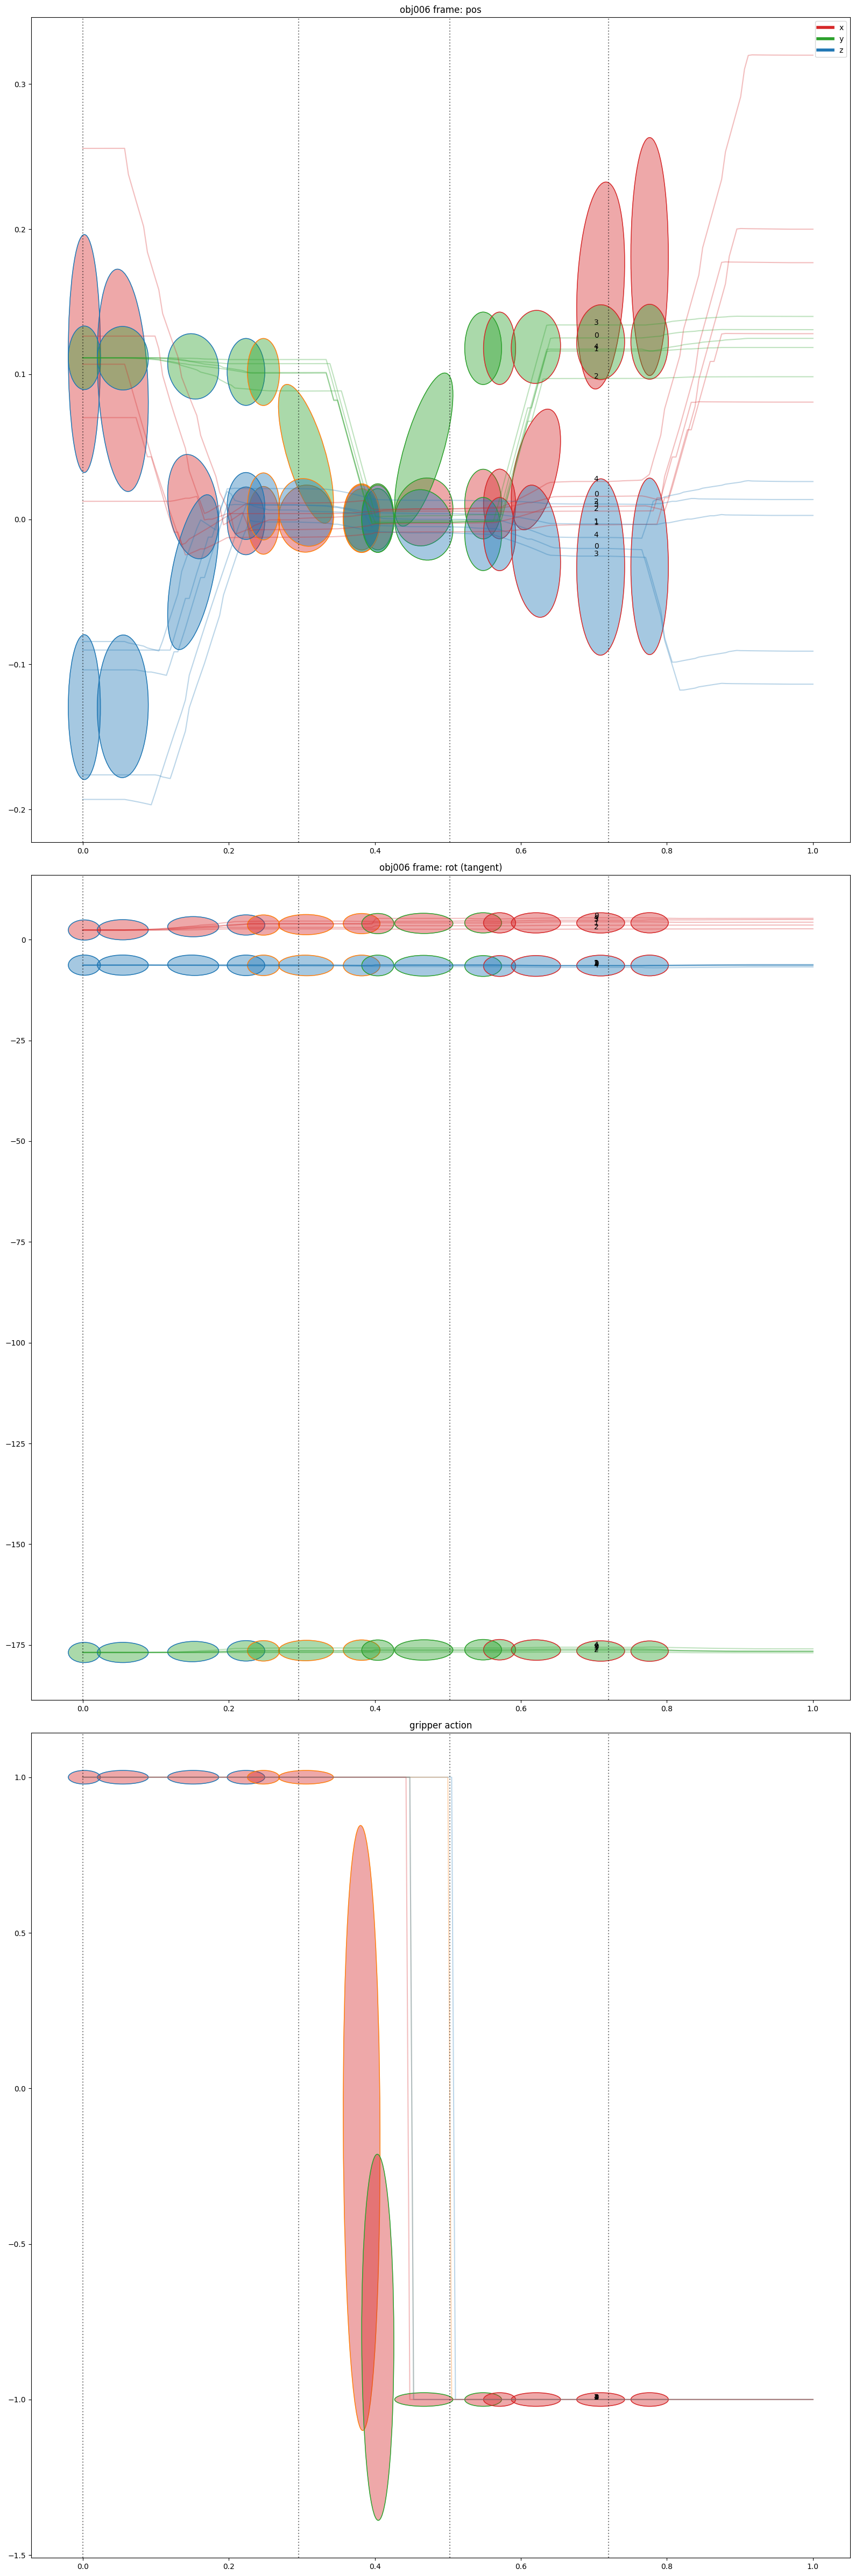

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-06 16:00:44.962 | INFO     |  Fitting AutoTPGMM
2025-08-06 16:00:44.962 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-06 16:00:44.977 | INFO     |  HMM EM ...
2025-08-06 16:00:44.985 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-06 16:00:45.057 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-06 16:00:52.193 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 9.98e-001, 9.87e-001, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.52e-060, 2.05e-003, 1.34e-002, ..., 8.37e-111, 1.86e-117,
          1.60e-121],
         [0.00e+000, 2.10e-150, 3.40e-088, ..., 1.40e-022, 4.19e-025,
          1.37e-026],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 9.97e-001, 9.65e-001, 6.69e-001,
          1.62e-001, 7.95e-003, 6.54e-005, 8.36e-008, 1.58e-011, 4.19e-016,
          1.46e-021, 7.05e-028, 1.82e-034, 2.23e-041, 1.28e-048, 3.47e-056,
          4.33e-064, 2.48e-072, 6.42e-081, 7.48e-090, 3.87e-099, 8.81e-109,
          8.65e-119, 3.62e-129, 6.42e-140, 4.75e-151, 1.46e-162, 1.84e-174,
          9.38e-187, 1.93e-199, 1.57e-212, 9.31e-225, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1

2025-08-06 16:01:05.706 | INFO     |  Did not specify time_based, deciding automatically.


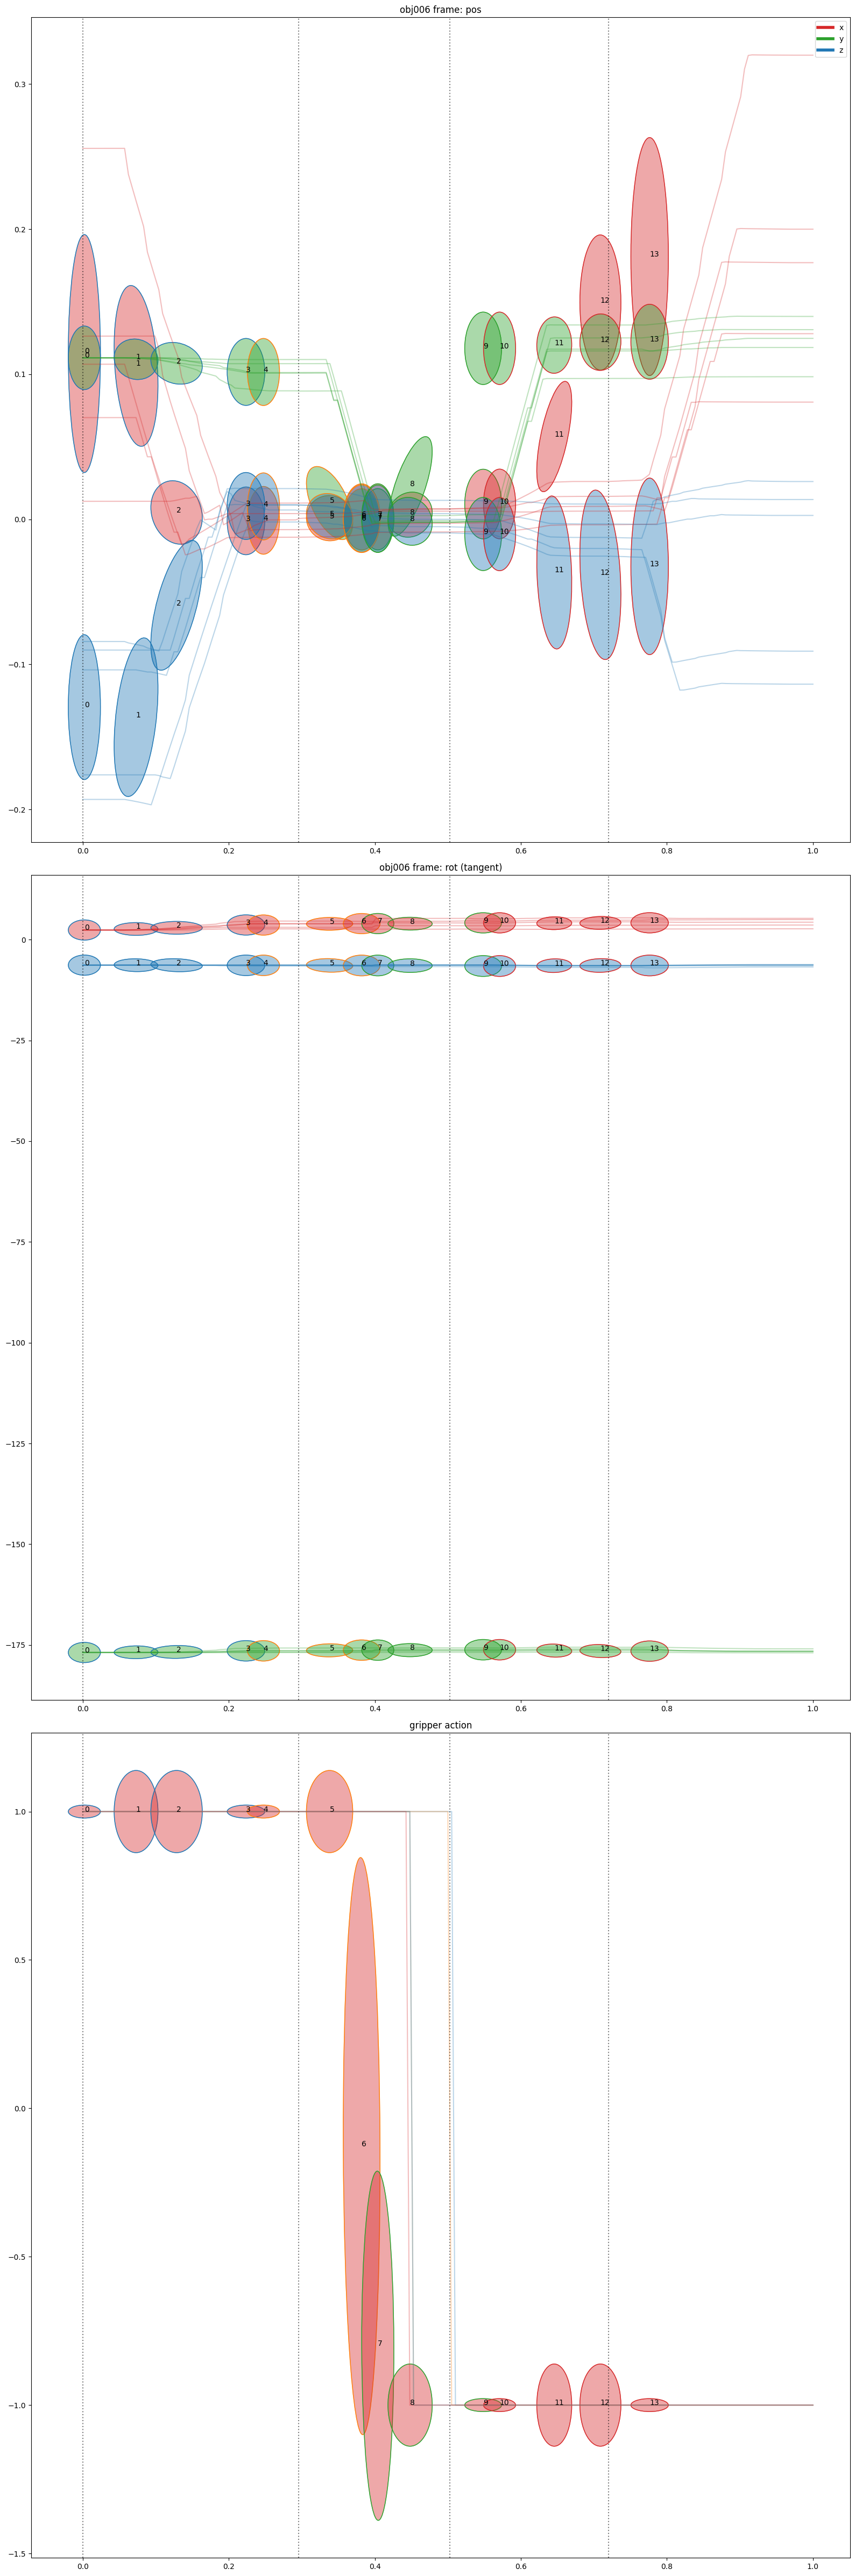

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

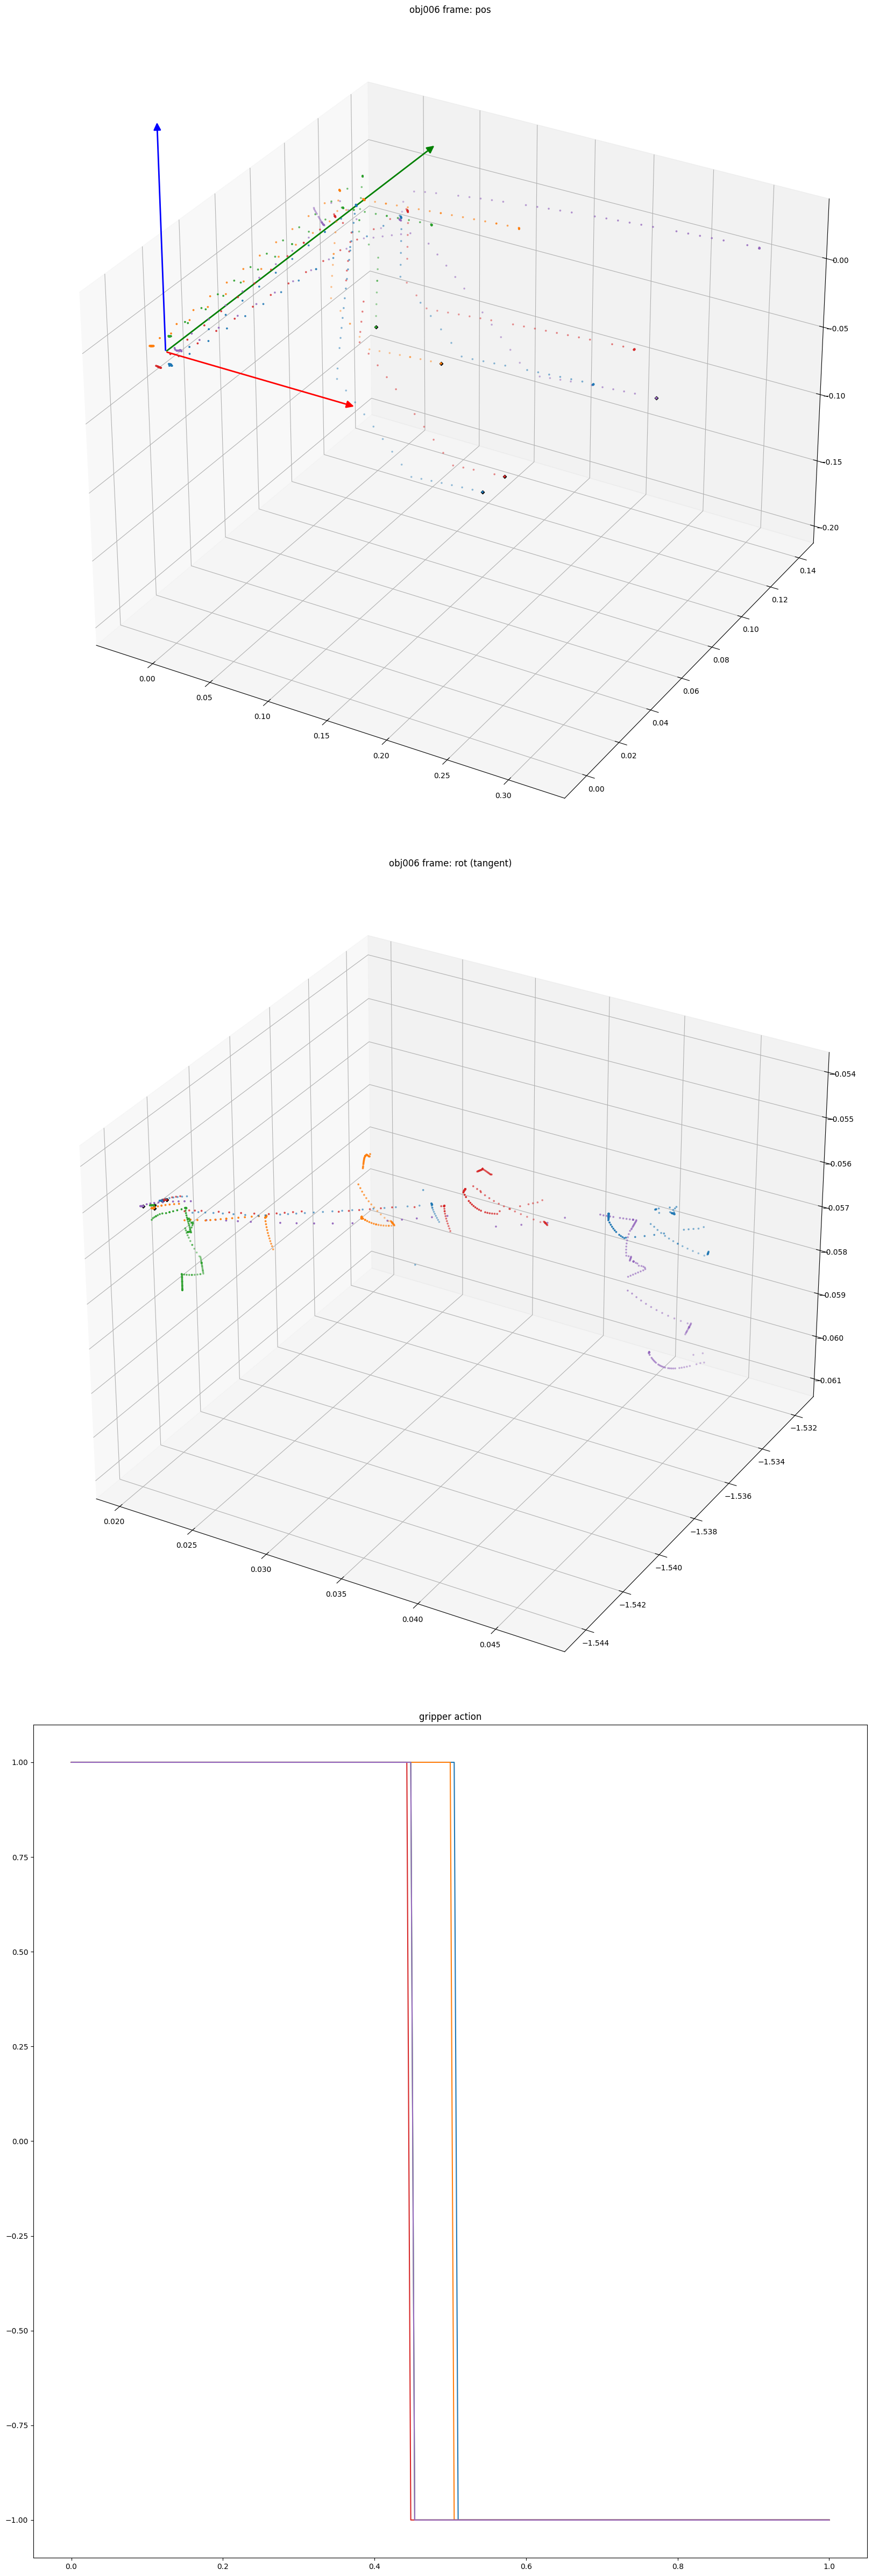

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

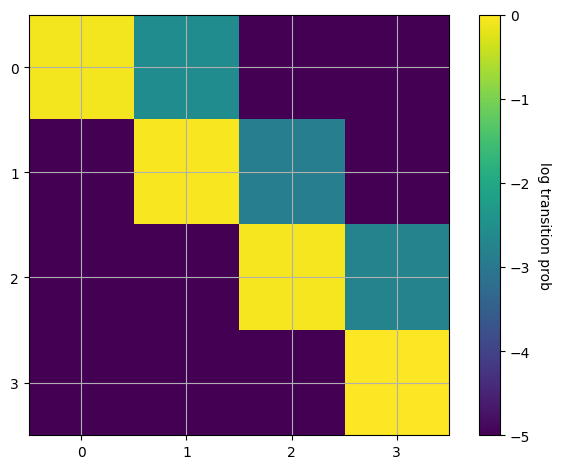

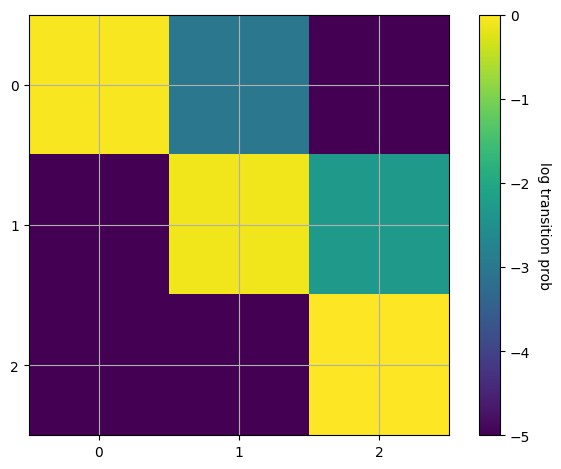

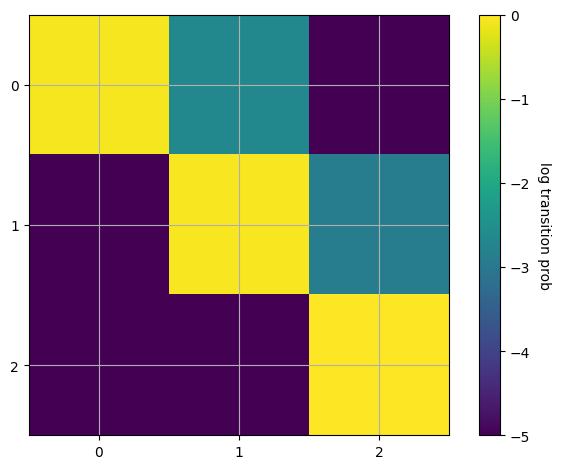

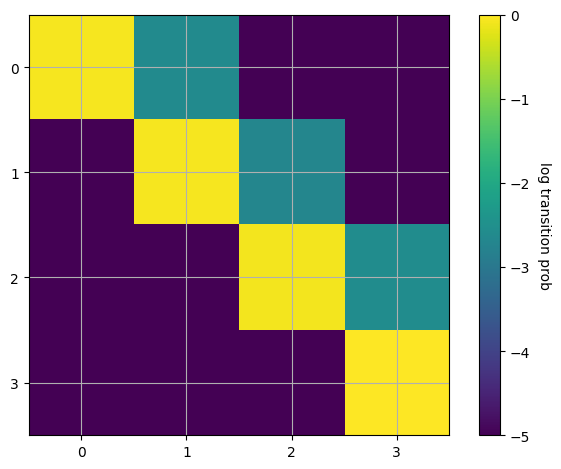

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-06 16:01:11.699 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-06 16:01:12.045 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-06 16:01:12.130 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-06 16:01:12.130 | INFO     |  Creating partial frame view of demos.
2025-08-06 16:01:12.217 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 16:01:12.299 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 16:01:12.365 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 16:01:12.428 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-06 16:01:12.502 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

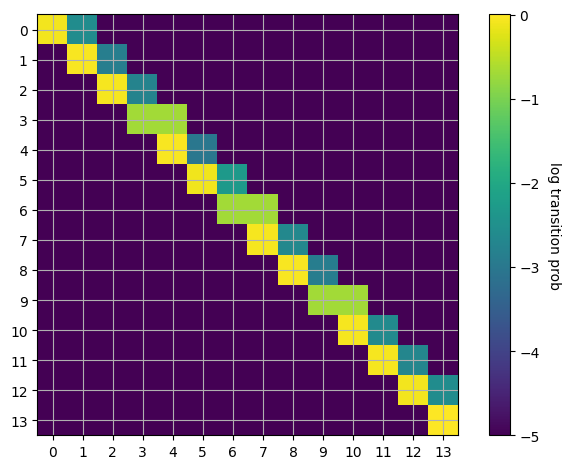

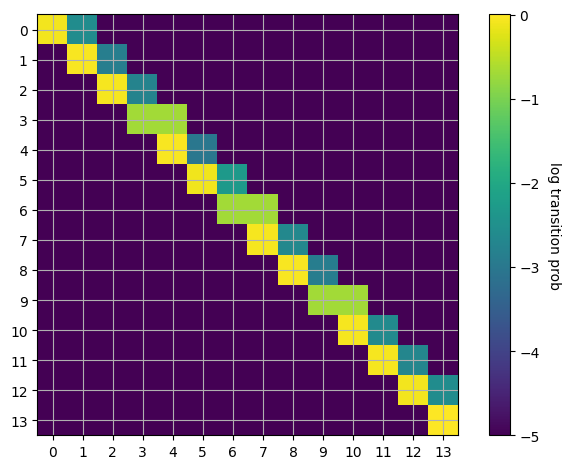

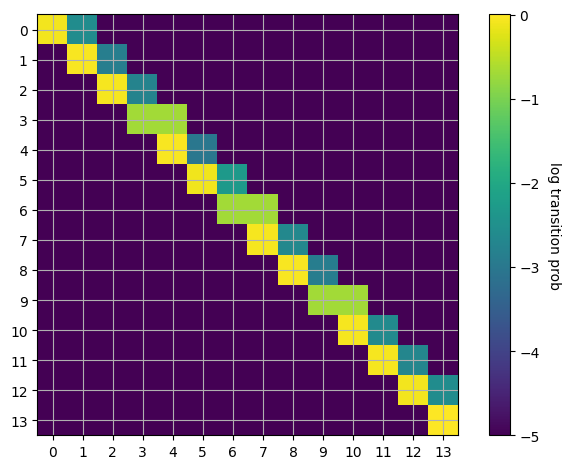

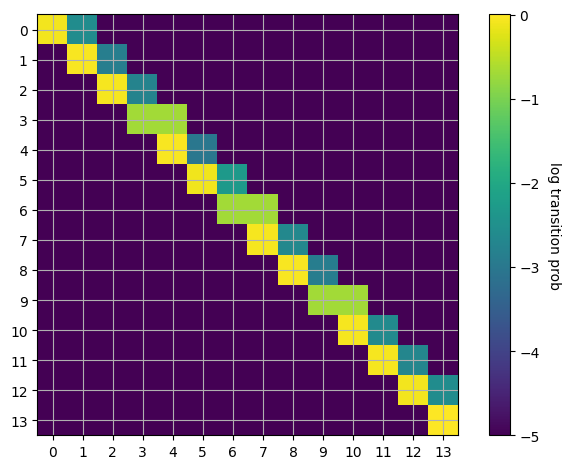

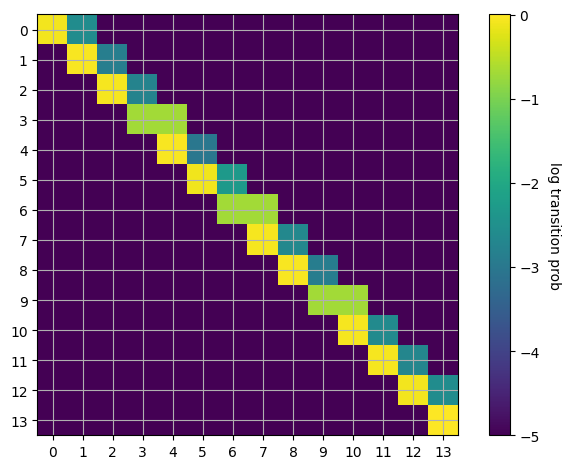

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-06 16:01:35.427 | INFO     |  Taking frame origins from demos.


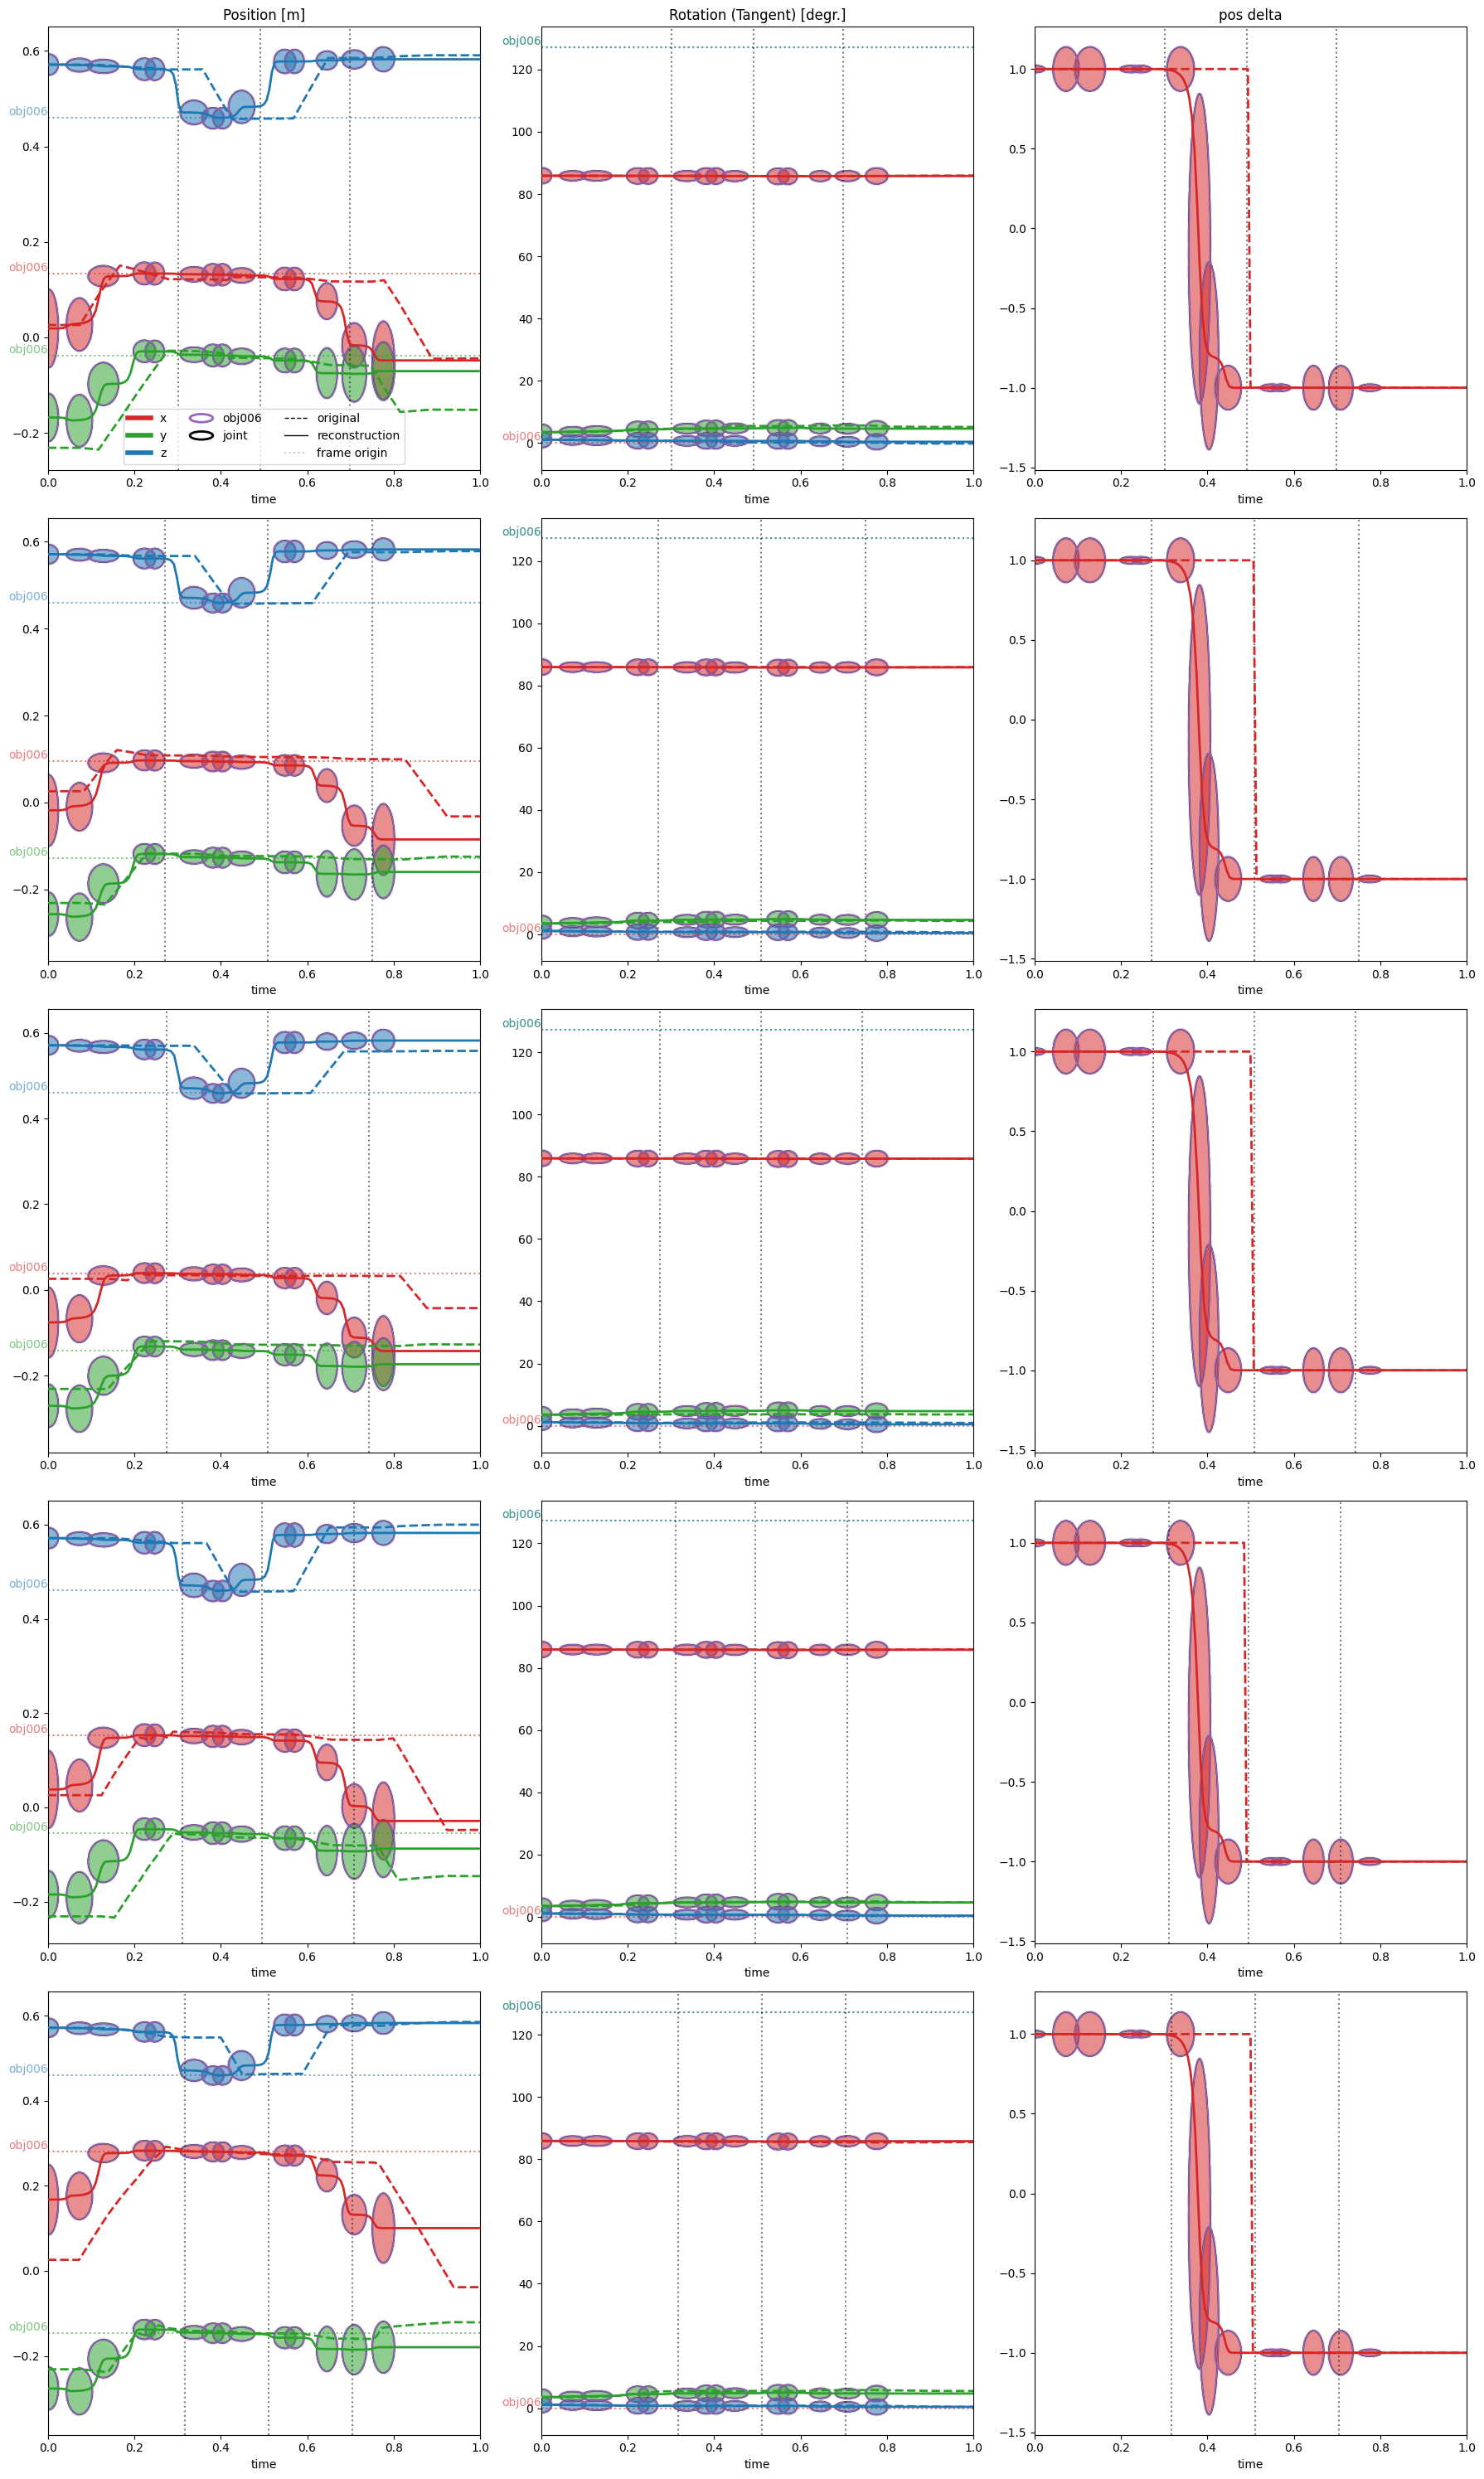

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range